The cells in the simulations have a fitness value that determines their behaviour.   
Usually these fitness values are fixed until a new mutation appears (although in most of the algorithms it is the *relative fitness* that is used to determine cell fate).  

It is possible to apply "treatments" that alter the fitness effects of genes.  
This could be used to simulate the competition of mutants with intermittent application of a drug that alters the competitive environment.   
For example, *NOTCH1* loss of function mutants are highly fit in normal oesophagus and a *NOTCH1* inhibitor would therefore alter the fitness of cells.   

We usually want to examine treatments that would alter only a subset of clones.  

There are therefore two scenarios in which treatments can be applied: 
1. Lineage tracing simulations. Define multiple initial clones. The treatment can then act differently on each initial clone. 
2. Mutations from multiple genes. The treatment can act differently on the non-synonymous mutations of each gene. 

In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize
%matplotlib inline

In [2]:
from clone_competition_simulation import Parameters, Gene, MutationGenerator, FixedValue, ColourScale
from collections import namedtuple

# Treatments to the initial clones 

I'll start with the simplest case: two competing clones.

,clone id,fitness
0,0,1.0
1,1,1.5


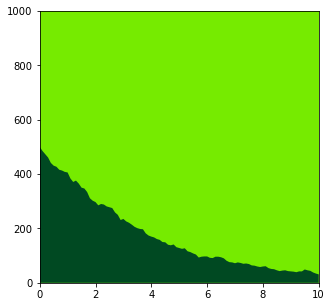

In [3]:
# Set up a simulation with 2 clones.  
np.random.seed(0)
p = Parameters(algorithm='Moran', print_warnings=False,
               initial_size_array=[500, 500],  # Start with equal clone sizes
               fitness_array=[1, 1.5]  # The second clone is fitter than the first
              )
s = p.get_simulator()
s.run_sim()
display(s.view_clone_info()[['clone id','fitness']])
s.muller_plot(figsize=(5, 5));

# The fitter clone (clone id=1, light green), easily wins

,clone id,fitness
0,0,1.00
1,1,0.75


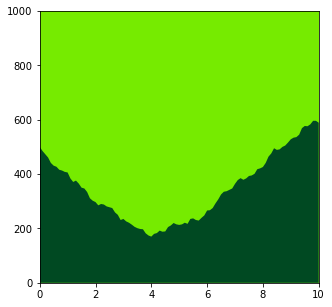

In [4]:
# Run the simulation again, but this time we will introduce a treatment that alters the cell fitness  
np.random.seed(0)
p = Parameters(algorithm='Moran', print_warnings=False,
               initial_size_array=[500, 500],  # Start with equal clone sizes
               fitness_array=[1, 1.5],  # The second clone is fitter than the first (at the start)
               
               # Define the treatment. 
               treatment_timings=[4],  # Start the treatment at time 4
               treatment_effects=[
                   [1, 0.5]  # One value per initial clone. 
               ],  
               treatment_replace_fitness=False   # The `treatment_effects` will multiply the fitness
              )
s = p.get_simulator()
s.run_sim()
display(s.view_clone_info()[['clone id','fitness']])
s.muller_plot(figsize=(5, 5));

# After the treatment, the fitness of the second clone is 1.5*0.5=0.75. 
# The fitness of the first clone remains the same (multiplied by 1)
# Can see the reversal of the competition trend from the time of the treatment. 

,clone id,fitness
0,0,1.0
1,1,1.5


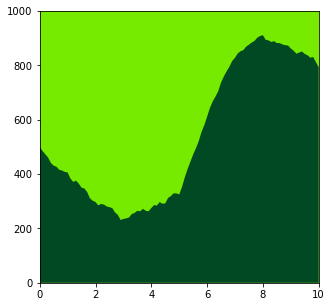

In [5]:
# You can have multiple treatment changes 
np.random.seed(0)
p = Parameters(algorithm='Moran', print_warnings=False,
               initial_size_array=[500, 500],  # Start with equal clone sizes
               fitness_array=[1, 1.5],  # The second clone is fitter than the first (at the start)
               
               # Define the treatment. 
               treatment_timings=[3, 5, 8],  # Change the treatments at these times
               treatment_effects=[
                   # One list per treatment, each with one value per initial clone. 
                   [1, 0.5],  # Lower the fitness of the second clone
                   [3, 0.5],  # Raise the fitness of the first clone, keep the second clone with lower fitness
                   [1, 1]   # Return to the original fitness values
               ],  
               treatment_replace_fitness=False   # The `treatment_effects` will multiply the fitness
              )
s = p.get_simulator()
s.run_sim()
display(s.view_clone_info()[['clone id','fitness']])  # Shows the fitness at the end of the simulation
s.muller_plot(figsize=(5, 5));

,clone id,fitness
0,0,1
1,1,1


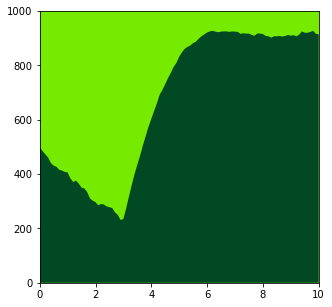

In [6]:
# In the previous examples, the `treatment_effects` multiply the original fitness of each clone. 
# Alternatively, you can replace the clone fitness values with the ones given in the `treatment_effects`
# to do this, set `treatment_replace_fitness=True`
# This can make it clearer what the fitness of each clone is during the treatments
np.random.seed(0)
p = Parameters(algorithm='Moran', print_warnings=False,
               initial_size_array=[500, 500],  # Start with equal clone sizes
               fitness_array=[1, 1.5],  # The second clone is fitter than the first (at the start)
               
               # Define the treatment. 
               treatment_timings=[3, 6],  # Change the treatments at these times
               treatment_effects=[
                   # One list per treatment, each with one value per initial clone. 
                   [3, 0.5],  # Raise the fitness of the first clone, keep the second clone with lower fitness
                   [1, 1]   # Make the competition neutral
               ],  
               treatment_replace_fitness=True   # The `treatment_effects` will now replace the fitness
              )
s = p.get_simulator()
s.run_sim()
display(s.view_clone_info()[['clone id','fitness']])  # Shows the fitness at the end of the simulation
s.muller_plot(figsize=(5, 5));

# Treatments affecting genes

To have treatment effects that depend on the gene mutated, run simulations with `MutationGenerator.multi_gene_array=True`.

This can also be used with the initial clones if `initial_mutant_gene_array` is used.  

## Initial clones (again)

If there are mutant genes associated with each of the initial clones, then the treatment can be based on those genes instead of the clone_id. 

In [7]:
# Define a MutationGenerator with a few genes
mut_gen = MutationGenerator(
    genes=[
        Gene('Gene1', FixedValue(1), synonymous_proportion=0), 
        Gene('Gene2', FixedValue(2), synonymous_proportion=0), 
        Gene('Gene3', FixedValue(3), synonymous_proportion=0)
    ], 
    multi_gene_array=True,   # This is the key argument for using treatment with genes
)

,clone id,label,fitness,generation born,parent clone id,last gene mutated,Initial clone fitness,Gene1,Gene2,Gene3
0,0,0,1,0,-1,Gene1,1.0,1.0,NaN,NaN
1,1,0,2,0,-1,Gene2,1.0,NaN,2.0,NaN
2,2,0,3,0,-1,Gene3,1.0,NaN,NaN,3.0


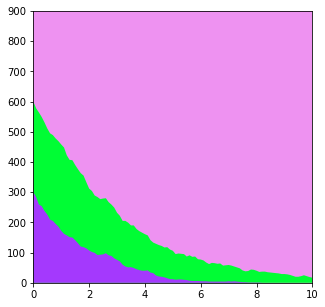

In [8]:
# Lets run with three initial clones, one mutant for each gene
np.random.seed(0)
p = Parameters(algorithm='Moran', print_warnings=False,
               mutation_generator=mut_gen, 
               initial_size_array=[300, 300, 300],  # Start with equal clone sizes
               fitness_array=[1, 2, 3],  # Have to define the initial fitness values
               initial_mutant_gene_array=[0, 1, 2]   # And define the genes mutated for each clone
              )
s = p.get_simulator()
s.run_sim()
display(s.view_clone_info(include_raw_fitness=True))
s.muller_plot(figsize=(5, 5));

,clone id,label,fitness,generation born,parent clone id,last gene mutated,Initial clone fitness,Gene1,Gene2,Gene3
0,0,0,1,0,-1,Gene1,1.0,1.0,NaN,NaN
1,1,0,4,0,-1,Gene2,1.0,NaN,2.0,NaN
2,2,0,3,0,-1,Gene3,1.0,NaN,NaN,3.0


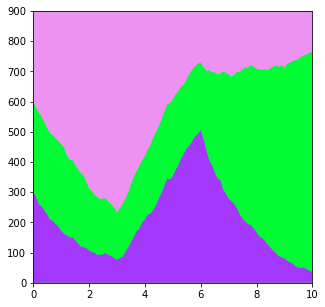

In [9]:
# Like before, we can introduce treatments that can alter the fitness
# For each treatment, there should be a value applied to the background fitness (will affect all cells), 
# plus a value for each gene defined in the MutationGenerator

np.random.seed(0)
p = Parameters(algorithm='Moran', print_warnings=False,
               mutation_generator=mut_gen, 
               initial_size_array=[300, 300, 300],  # Start with equal clone sizes
               fitness_array=[1, 2, 3],  # Have to define the initial fitness values
               initial_mutant_gene_array=[0, 1, 2],   # And define the genes mutated for each clone
               
               # Define the treatment. 
               treatment_timings=[3, 6],  # Change the treatments at these times
               treatment_effects=[
                   # One list per treatment, each with one value per initial clone. 
                   [1, 3, 1, 1/3],  # Reverse the fitness values
                   [1, 1, 2, 1]   # Make the second clone the fittest
               ],  
               treatment_replace_fitness=False   # The `treatment_effects` will multiply fitness
              )
s = p.get_simulator()
s.run_sim()
display(s.view_clone_info(include_raw_fitness=True))
s.muller_plot(figsize=(5, 5));

# Notice now that the fitness column in the table is not a simple sum of the fitness values from the Gene columns. 
# It includes the effects of the treatments.  

## Random ongoing mutations

To apply treatments to mutations that appear after the start of the simulation, treatment must be based on the genes mutated. 

In [10]:
# To keep it simple, set up a MutationGenerator and a ColourScale for two genes. 

mut_gen = MutationGenerator(
    genes=[
        Gene('Gene1', FixedValue(1), synonymous_proportion=0),
        Gene('Gene2', FixedValue(3), synonymous_proportion=0)
    ], 
    multi_gene_array=True, 
    combine_mutations='replace',  # Further mutations in the same gene won't increase cell fitness
    combine_array='add'   # Add the fitness values from different genes
)

Key = namedtuple('key', ['genes_mutated', ])

cs = ColourScale(
    colourmaps={
        # No genes mutated, light blue colour
        Key(genes_mutated=(0,)): cm.ScalarMappable(norm=Normalize(vmin=0, vmax=2), cmap=cm.Blues).to_rgba,  
        
        # First gene mutated, Red
        Key(genes_mutated=(0, 1,)): cm.ScalarMappable(norm=Normalize(vmin=-2, vmax=2), cmap=cm.Reds).to_rgba, 
        
        # Second gene mutated, yellow
        Key(genes_mutated=(0, 2,)): cm.ScalarMappable(norm=Normalize(vmin=-20, vmax=2), cmap=cm.inferno).to_rgba,
        
        # Both genes mutated, purple
        Key(genes_mutated=(0, 1, 2)): cm.ScalarMappable(norm=Normalize(vmin=-5, vmax=1), cmap=cm.Purples).to_rgba
    }, 
    use_fitness=False
)

In [11]:
# Now start from a single wild type clone and introduce mutations at random.  
np.random.seed(0)
p = Parameters(algorithm='Moran', print_warnings=False,
               mutation_generator=mut_gen, 
               mutation_rates=0.01,
               initial_cells=1000,  
               colourscales=cs,
               
               # Define the treatment. 
               treatment_timings=[5],  # Change the treatment at this time
               treatment_effects=[
                   # One list per treatment, each with one value per initial clone. 
                   [1, 3, 1],  # Make mutants in the first gene fitter, and mutants in the second gene neutral
               ],  
               treatment_replace_fitness=True   # The `treatment_effects` will replace the previous fitness
              )
s = p.get_simulator()
s.run_sim()

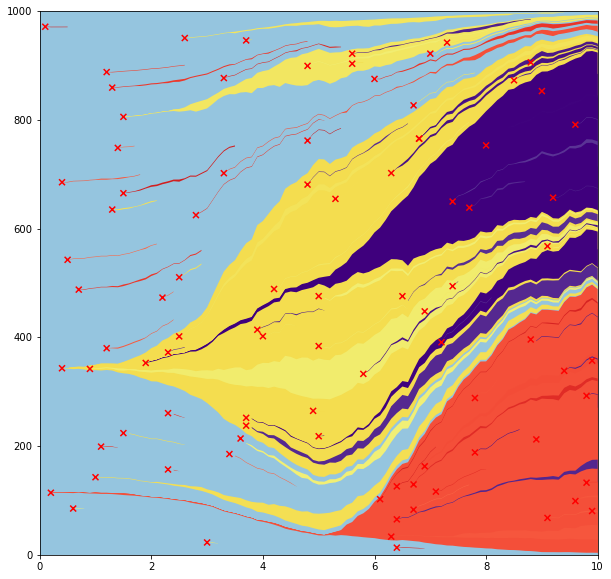

In [12]:
# At the start, the mutants in the first gene (yellow) are highly fit and expand
# The mutants in the second gene (red) are neutral, and do not grow much or die out. 

# After the treatment starts (t=5), the yellow clones are neutral, and stop expanding. 
# The red clones are now fit, and do expand. 
# The purple clones have both mutations, and are highly fit both before and during the treatment

s.muller_plot(figsize=(10, 10));